<a href="https://colab.research.google.com/github/palexey2006/Ml-Engineering/blob/main/CIFAR10_efficient_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

100%|██████████| 170M/170M [00:02<00:00, 76.2MB/s]


Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


100%|██████████| 170M/170M [00:02<00:00, 73.0MB/s]


Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


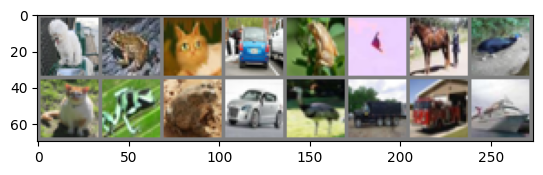

Started training
epoch 1 / 5, step 100 / 3125, loss 1.5380
epoch 1 / 5, step 200 / 3125, loss 1.7022
epoch 1 / 5, step 300 / 3125, loss 1.4412
epoch 1 / 5, step 400 / 3125, loss 1.5560
epoch 1 / 5, step 500 / 3125, loss 1.3820
epoch 1 / 5, step 600 / 3125, loss 1.4887
epoch 1 / 5, step 700 / 3125, loss 1.3132
epoch 1 / 5, step 800 / 3125, loss 0.8232
epoch 1 / 5, step 900 / 3125, loss 1.6501
epoch 1 / 5, step 1000 / 3125, loss 1.0442
epoch 1 / 5, step 1100 / 3125, loss 1.3881
epoch 1 / 5, step 1200 / 3125, loss 1.5192
epoch 1 / 5, step 1300 / 3125, loss 1.1278
epoch 1 / 5, step 1400 / 3125, loss 1.2655
epoch 1 / 5, step 1500 / 3125, loss 1.0164
epoch 1 / 5, step 1600 / 3125, loss 1.0912
epoch 1 / 5, step 1700 / 3125, loss 1.4487
epoch 1 / 5, step 1800 / 3125, loss 1.5900
epoch 1 / 5, step 1900 / 3125, loss 1.2501
epoch 1 / 5, step 2000 / 3125, loss 0.9772
epoch 1 / 5, step 2100 / 3125, loss 1.0032
epoch 1 / 5, step 2200 / 3125, loss 1.0243
epoch 1 / 5, step 2300 / 3125, loss 1.5477
epo

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

#setting up hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lr = 0.05
batch_size = 16
epochs = 5
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])


#setting up a dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data/train',train=True,transform=transform,download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./data/test',train=False,transform=transform,download=True)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=True)

#define a func that showing images on the plot
def imshow(img):
    #since formula to normalize data is x_normalized = X_original - mean / std
    # in that case it will be x_normalized = x_original - 0.5 / 0.5
    #so to unnormalize data we will use formula x_original = x_normalized * std + mean
    # in that case it will be x_original = x_normalized * 0.5 + 0.5 or x_norm / 2 + 0.5
    #unnormalizing our images
    image = img * 0.5 + 0.5
    #converting image to numpy
    numpy_image = image.numpy()
    # transpose means changing shape of an image from 3[0 index],32[1 index],32[2 index] where 3 is the number of channels(RGB),
    # 32 and 32 is the size of an image, since imshow() accepts only size and that channels we transpose and reshaping
    # images to 32,32,3
    #                            same as(32,32,3)
    plt.imshow(np.transpose(numpy_image, (1, 2, 0)))
    plt.show()

#getting some images from dataset
dataiter = iter(train_loader)
images, labels = next(dataiter)
imshow(torchvision.utils.make_grid(images))
#creating a model
class ConvNN(nn.Module):
    def __init__(self):
        super(ConvNN, self).__init__()
        # output size = ((input size - kernel size + 2 * padding) / stride) + 1
        #input size is 32x32x3
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=32,kernel_size=3, stride=2)
        self.bn1 = nn.BatchNorm2d(32)
        #Downscale from 32x32 to 16x16
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3, stride=2)
        self.bn2 = nn.BatchNorm2d(64)
        #Downscale from 16x16 to 8x8
        self.conv3 = nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3, stride=2)
        self.bn3 = nn.BatchNorm2d(128)
        #Downscale from 8x8 to 4x4
        self.conv4 = nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3, stride=2)
        self.bn4 = nn.BatchNorm2d(256)
        #Downscale from 4x4 to 2x2
        self.global_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(256,10)
    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.global_pool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

model = ConvNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
total_steps = len(train_loader)
#training a model
print("Started training")
for epoch in range(epochs):
    for step, (images, labels) in enumerate(train_loader):
        #input layer
        images,labels = images.to(device), labels.to(device)
        #forward passing
        outputs = model(images)
        loss = criterion(outputs, labels)
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (step + 1) % 100 == 0:
            print(f'epoch {epoch + 1} / {epochs}, step {step + 1} / {total_steps}, loss {loss.item():.4f}')


print('Finished Training')
#testing a model
with torch.no_grad():
    correct = 0
    total = 0
    correct_classes = [0 for i in range(10)]
    sample_classes = [0 for i in range(10)]
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        for i in range(batch_size):
            label = labels[i]
            prediction = predicted[i]
            if label == prediction:
                correct_classes[label] += 1
            sample_classes[label] += 1
    accuracy = 100.0 * correct / total
    print(f'Accuracy: {accuracy:.4f}')

    for i in range(10):
        accuracy_per_class = 100.0 * correct_classes[i]/sample_classes[i]
        print(f'Accuracy for class {i}: {accuracy_per_class:.4f}')
torch.save(model.state_dict(), 'CNN_CIFAR10_model.pth')